# **Personal Expense** **Tracker**

#**Feature Engineering and predective modelling**


1. Import packages
2. Load data
3. Feature Engineering and Modelling


## 1. Import packages

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime



## 2. Load Data

In [ ]:
data_df = pd.read_csv('updated_data.csv')
data_df.head()

,Mode,Category,Subcategory,Note,Amount,Income/Expense,Currency,Day,Month,Year,...,Income,Expense,Cumulative Income,Savings,Category Count,Subcategory Count,Category Total Expense,Subcategory Total Expense,Category Average Expense,Subcategory Average Expense
0,Cash,Transportation,Train,2 Place 5 to Place 0,30.0,Expense,INR,20,9,2018,...,0.0,30.0,0.0,-30.0,199,40,143066.00,1210.00,718.924623,30.250000
1,Cash,Food,snacks,Idli medu Vada mix 2 plates,60.0,Expense,INR,20,9,2018,...,0.0,60.0,0.0,-90.0,516,73,55517.90,3945.75,107.592829,54.051370
2,Saving Bank account 1,subscription,Mobile Service Provider,Data booster pack,19.0,Expense,INR,17,9,2018,...,0.0,19.0,0.0,-109.0,79,42,59933.49,16666.00,758.651772,396.809524
3,Cash,Festivals,Ganesh Pujan,Ganesh idol,251.0,Expense,INR,16,9,2018,...,0.0,251.0,0.0,-360.0,11,2,5391.00,612.00,490.090909,306.000000
4,Credit Card,subscription,Tata Sky,Permanent Residence - Tata Play recharge,200.0,Expense,INR,15,9,2018,...,0.0,200.0,0.0,-560.0,79,20,59933.49,3382.00,758.651772,169.100000


In [ ]:
#Checking the shape (number of rows and columns)
print("Dataset Shape:", data_df.shape)

Dataset Shape: (1303, 32)


# Expense Prediction Model:
Problem Statement: Predict the total monthly expense for the user based on historical spending data.

# 3.Feature engineering and Modelling

In [ ]:

# Load the dataset (assuming it's in the correct directory)
data_df = pd.read_csv('updated_data.csv')

# Step 1: Data Preprocessing and Feature Creation
# Convert 'Year', 'Month', and 'Day' to datetime
data_df['Date'] = pd.to_datetime(data_df[['Year', 'Month', 'Day']])
data_df.set_index('Date', inplace=True)

# Aggregating monthly expenses
monthly_data = data_df.resample('M').agg({
    'Amount': 'sum',
    'Income/Expense': lambda x: x.iloc[0],
    'Category': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
})

# Create new features for predictive modeling
monthly_data['Previous_Month_Expense'] = monthly_data['Amount'].shift(1)

# Income-to-Expense Ratio
monthly_income = data_df[data_df['Income/Expense'] == 'Income'].resample('M')['Amount'].sum()
monthly_data['Income'] = monthly_income
monthly_data['Income'].fillna(0, inplace=True)
monthly_data['Income_to_Expense_Ratio'] = monthly_data['Income'] / (monthly_data['Amount'] + 1e-9)

# Recurring Expense Amount Calculation
recurring_expenses = data_df[data_df['Income/Expense'] == 'Expense'].groupby(['Category']).filter(lambda x: len(x) >= 3)
monthly_recurring_expense = recurring_expenses.groupby(['Category']).resample('M')['Amount'].sum().reset_index(level=0, drop=True)

# Merge recurring expenses with the main monthly data
monthly_data = monthly_data.merge(monthly_recurring_expense, left_index=True, right_index=True, how='left', suffixes=('', '_Recurring'))
monthly_data.fillna(0, inplace=True)  # Replace missing values with 0

# Add Monthly Aggregation of Categories - Fixed Version
monthly_category_expenses = data_df.pivot_table(
    index=data_df.index.to_period('M'),
    columns='Category',
    values='Amount',
    aggfunc='sum'
)

# Fill missing values with 0 for categories with no expenses in a given month
monthly_category_expenses.fillna(0, inplace=True)

# Merge the category expenses with the main monthly data
monthly_data = monthly_data.merge(monthly_category_expenses, left_index=True, right_index=True, how='left')
monthly_data.fillna(0, inplace=True)

# Add Seasonal Features - Fixed Version
# Convert index back to datetime to extract month
monthly_data.index = pd.to_datetime(monthly_data.index.astype(str))
monthly_data['Holiday_Season'] = monthly_data.index.month.isin([12, 1]).astype(int)



In [ ]:
monthly_data.head(10)

,Amount,Income/Expense,Category,Previous_Month_Expense,Income,Income_to_Expense_Ratio,Amount_Recurring,Amazon pay cashback,Apparel,Beauty,...,Share Market,Social Life,Tax refund,Tourism,Transportation,maid,scrap,subscription,water (jar /tanker),Holiday_Season
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-31,4434.0,Expense,Food,0.0,0.0,0.000000,60.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2015-01-31,4434.0,Expense,Food,0.0,0.0,0.000000,2362.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2015-01-31,4434.0,Expense,Food,0.0,0.0,0.000000,60.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2015-01-31,4434.0,Expense,Food,0.0,0.0,0.000000,500.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2015-01-31,4434.0,Expense,Food,0.0,0.0,0.000000,1452.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2015-02-28,56516.0,Expense,Food,4434.0,49806.0,0.881273,20.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2015-02-28,56516.0,Expense,Food,4434.0,49806.0,0.881273,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2015-02-28,56516.0,Expense,Food,4434.0,49806.0,0.881273,972.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2015-02-28,56516.0,Expense,Food,4434.0,49806.0,0.881273,79.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
#Checking the shape (number of rows and columns)
print("Dataset Shape:", monthly_data.shape)

Dataset Shape: (525, 45)


In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1303 entries, 2018-09-20 to 2015-01-13
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Mode                         1303 non-null   object 
 1   Category                     1303 non-null   object 
 2   Subcategory                  1303 non-null   object 
 3   Note                         1303 non-null   object 
 4   Amount                       1303 non-null   float64
 5   Income/Expense               1303 non-null   object 
 6   Currency                     1303 non-null   object 
 7   Day                          1303 non-null   int64  
 8   Month                        1303 non-null   int64  
 9   Year                         1303 non-null   int64  
 10  Time                         1303 non-null   object 
 11  Amount_log                   1303 non-null   float64
 12  Season                       1303 non-null   object 
 13  

**data sampling and model training**

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [ ]:

# Aggregate additional columns from data_df to monthly level
monthly_aggregated_features = data_df.resample('M').agg({
    'Mode': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',
    'Category': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',
    'Subcategory': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',
    'Income': 'sum',
    'Savings': 'sum',
    'Expense Stability': lambda x: x.mode()[0] if not x.mode().empty else 'Stable',
    'Expense Frequency': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
})

#  Combining Monthly Features with Aggregated Features
combined_features = pd.concat([monthly_data, monthly_aggregated_features], axis=1)
combined_features.fillna(0, inplace=True)

# Adding 'Month' and 'Year' features to the feature matrix
combined_features['Month'] = combined_features.index.month
combined_features['Year'] = combined_features.index.year

# Defining the updated feature matrix (X) and target variable (y)
y = combined_features['Amount']  # Target variable representing monthly expense
X = combined_features.drop('Amount', axis=1)  # Dropping 'Amount' from features

# Handling categorical variables: One-hot encoding for categorical features
X = pd.get_dummies(X)

# Splitting the dataset into training and testing sets (75-25 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Displaying the shape of training and testing sets
print(f"Training Set Size: {X_train.shape[0]} samples")
print(f"Testing Set Size: {X_test.shape[0]} samples")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


Training Set Size: 393 samples
Testing Set Size: 132 samples
(393, 76)
(393,)
(132, 76)
(132,)


Let us build a linear Regression model as baseline model

In [ ]:
# Import required libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score




# Step 1: Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Step 2: Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)

# Step 3: Evaluate the Linear Regression model

# Mean Absolute Error (MAE)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

# Mean Squared Error (MSE)
mse_lr = mean_squared_error(y_test, y_pred_lr)

# Root Mean Squared Error (RMSE)
rmse_lr = np.sqrt(mse_lr)

# R-squared (R²) Score
r2_lr = r2_score(y_test, y_pred_lr)

# Print the evaluation metrics
print(f"Linear Regression - Mean Absolute Error (MAE): {mae_lr:.2f}")
print(f"Linear Regression - Mean Squared Error (MSE): {mse_lr:.2f}")
print(f"Linear Regression - Root Mean Squared Error (RMSE): {rmse_lr:.2f}")
print(f"Linear Regression - R-squared (R²): {r2_lr:.2f}")




Linear Regression - Mean Absolute Error (MAE): 24089.38
Linear Regression - Mean Squared Error (MSE): 1335434861.43
Linear Regression - Root Mean Squared Error (RMSE): 36543.60
Linear Regression - R-squared (R²): 0.72


Linear Regression seems to have a relatively high error (MAE and RMSE), and the R² score of 0.72 indicates that it explains about 72% of the variance in the data. The high RMSE value suggests that the predictions might be significantly off from the true values. This could indicate that the linear model is underfitting the data and failing to capture the underlying non-linear relationships in the dataset.

# Random forest Regressor

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor

# Step 1: Train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 2: Make Predictions
y_pred_rf = rf_model.predict(X_test)

# Step 3: Evaluate the Random Forest Regressor using metrics

# Mean Absolute Error (MAE)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

# Mean Squared Error (MSE)
mse_rf = mean_squared_error(y_test, y_pred_rf)

# Root Mean Squared Error (RMSE)
rmse_rf = np.sqrt(mse_rf)

# R-squared (R²) Score
r2_rf = r2_score(y_test, y_pred_rf)

# Print the evaluation metrics
print(f"Random Forest Regressor - Mean Absolute Error (MAE): {mae_rf:.2f}")
print(f"Random Forest Regressor - Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"Random Forest Regressor - Root Mean Squared Error (RMSE): {rmse_rf:.2f}")
print(f"Random Forest Regressor - R-squared (R²): {r2_rf:.2f}")


Random Forest Regressor - Mean Absolute Error (MAE): 1112.12
Random Forest Regressor - Mean Squared Error (MSE): 34764482.45
Random Forest Regressor - Root Mean Squared Error (RMSE): 5896.14
Random Forest Regressor - R-squared (R²): 0.99


The Random Forest Regressor performed well with an R-squared (R²) value of 0.99, indicating it explained most of the variance in the data. The Mean Absolute Error (MAE) of 1112.12 and Root Mean Squared Error (RMSE) of 5896.14 suggest that, while the overall model fit is strong, individual predictions still have some errors that need to be addressed. Overall, the model is quite effective, but there's still room for improvement in reducing prediction errors. Can also indicate overfitting of data.

# GradientBoosting Regressor

In [ ]:
# Importing necessary libraries

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Assuming 'combined_features' is our final dataset containing the target and features

# Step 1: Train-Test Split
X = combined_features.drop(columns=['Amount'])  # Features (independent variables)
y = combined_features['Amount']  # Target variable (dependent variable)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Step 2: Handle categorical data using One-Hot Encoding
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Ensure the columns in the test set match those in the training set
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Step 3: Train the Gradient Boosting Regressor model
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr_model.fit(X_train, y_train)

# Step 4: Make Predictions
y_pred_gbr = gbr_model.predict(X_test)

# Step 5: Evaluate the Gradient Boosting Regressor using metrics

# Mean Absolute Error (MAE)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)

# Mean Squared Error (MSE)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)

# Root Mean Squared Error (RMSE)
rmse_gbr = np.sqrt(mse_gbr)

# R-squared (R²) Score
r2_gbr = r2_score(y_test, y_pred_gbr)

# Print the evaluation metrics
print(f"Gradient Boosting Regressor - Mean Absolute Error (MAE): {mae_gbr:.2f}")
print(f"Gradient Boosting Regressor - Mean Squared Error (MSE): {mse_gbr:.2f}")
print(f"Gradient Boosting Regressor - Root Mean Squared Error (RMSE): {rmse_gbr:.2f}")
print(f"Gradient Boosting Regressor - R-squared (R²): {r2_gbr:.2f}")


Gradient Boosting Regressor - Mean Absolute Error (MAE): 244.64
Gradient Boosting Regressor - Mean Squared Error (MSE): 86170.57
Gradient Boosting Regressor - Root Mean Squared Error (RMSE): 293.55
Gradient Boosting Regressor - R-squared (R²): 1.00


The Gradient Boosting Regressor has a very low MAE of 244.64 and a perfect R² of 1.00, indicating excellent predictive accuracy. However, the perfect R² may suggest overfitting, meaning the model might have captured noise along with trends, potentially affecting its generalizability to new data.

# **Hyperparameter Tuning for Enhanced Model Performance**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


# Define the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20, None],  # Adding smaller max depth values to prevent overfitting
    'min_samples_split': [2, 5, 10],  # Controlling the depth of the tree
    'min_samples_leaf': [1, 2, 5],  # Increase leaf size to reduce overfitting
    'max_features': ['sqrt', 'log2'],  # Removed 'auto' to avoid errors
}

# Set up the GridSearchCV with 5-fold cross-validation
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearch to the data
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and the tuned model
best_params_rf = grid_search_rf.best_params_
tuned_rf = grid_search_rf.best_estimator_

# Print the best parameters
print(f"Best Parameters for Random Forest: {best_params_rf}")

# Make predictions on the test set
y_pred_rf_tuned = tuned_rf.predict(X_test)

# Evaluate the tuned model using the same metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Mean Absolute Error (MAE)
mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)

# Mean Squared Error (MSE)
mse_rf_tuned = mean_squared_error(y_test, y_pred_rf_tuned)

# Root Mean Squared Error (RMSE)
rmse_rf_tuned = np.sqrt(mse_rf_tuned)

# R-squared (R²) Score
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)

# Print the evaluation metrics for the tuned model
print(f"Tuned Random Forest - Mean Absolute Error (MAE): {mae_rf_tuned:.2f}")
print(f"Tuned Random Forest - Mean Squared Error (MSE): {mse_rf_tuned:.2f}")
print(f"Tuned Random Forest - Root Mean Squared Error (RMSE): {rmse_rf_tuned:.2f}")
print(f"Tuned Random Forest - R-squared (R²): {r2_rf_tuned:.2f}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters for Random Forest: {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Tuned Random Forest - Mean Absolute Error (MAE): 1363.32
Tuned Random Forest - Mean Squared Error (MSE): 19495414.34
Tuned Random Forest - Root Mean Squared Error (RMSE): 4415.36
Tuned Random Forest - R-squared (R²): 1.00


After hyperparameter tuning, the performance of the Random Forest Regressor improved significantly. The tuned model resulted in a much lower Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE), demonstrating better accuracy and more precise predictions. The R-squared (R²) score of 1.00 indicates the model explains the variance in the data very well, minimizing both bias and variance effectively. This highlights the impact of adjusting parameters such as the depth, the number of estimators, and feature selection, optimizing the model's generalizability and reducing overfitting.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define parameter grid for Gradient Boosting Regressor with reduced complexity
param_grid_gb = {
    'n_estimators': [50, 100, 150],  # Reduced number of trees
    'max_depth': [3, 5, 7],          # Limit tree depth
    'learning_rate': [0.01, 0.05, 0.1],  # Lower learning rates
    'min_samples_split': [10, 20],   # Prevent overfitting by increasing minimum samples per split
    'min_samples_leaf': [3, 5],      # Increase minimum samples per leaf
    'subsample': [0.7, 0.8, 1.0]     # Subsample to introduce randomness
}

# Initialize Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Set up GridSearchCV with the updated parameter grid
grid_search_gb = GridSearchCV(estimator=gbr, param_grid=param_grid_gb, cv=5, n_jobs=-1, verbose=1)

# Fit the GridSearchCV to the training data
grid_search_gb.fit(X_train, y_train)

# Extract the best model from GridSearchCV
best_gb = grid_search_gb.best_estimator_

# Make predictions on the test set
y_pred_gb = best_gb.predict(X_test)

# Evaluate the tuned Gradient Boosting Regressor using metrics
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb)

# Print the evaluation metrics
print(f"Best Parameters for Gradient Boosting: {grid_search_gb.best_params_}")
print(f"Tuned Gradient Boosting Regressor - Mean Absolute Error (MAE): {mae_gb:.2f}")
print(f"Tuned Gradient Boosting Regressor - Mean Squared Error (MSE): {mse_gb:.2f}")
print(f"Tuned Gradient Boosting Regressor - Root Mean Squared Error (RMSE): {rmse_gb:.2f}")
print(f"Tuned Gradient Boosting Regressor - R-squared (R²): {r2_gb:.2f}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 20, 'n_estimators': 150, 'subsample': 1.0}
Tuned Gradient Boosting Regressor - Mean Absolute Error (MAE): 21.74
Tuned Gradient Boosting Regressor - Mean Squared Error (MSE): 3225.07
Tuned Gradient Boosting Regressor - Root Mean Squared Error (RMSE): 56.79
Tuned Gradient Boosting Regressor - R-squared (R²): 1.00


The hyperparameter tuning of the Gradient Boosting Regressor significantly improved the model's performance, as evidenced by the very low Mean Absolute Error (MAE) of 21.74 and a Root Mean Squared Error (RMSE) of 56.79. The R-squared (R²) score of 1.00 suggests that the tuned model almost perfectly fits the training data, capturing all the variance. This tuning effectively reduced prediction errors, indicating that the combination of optimized parameters like learning rate, depth, and estimators has maximized accuracy while balancing complexity to avoid overfitting.

Actual Values Vs Predicted Values

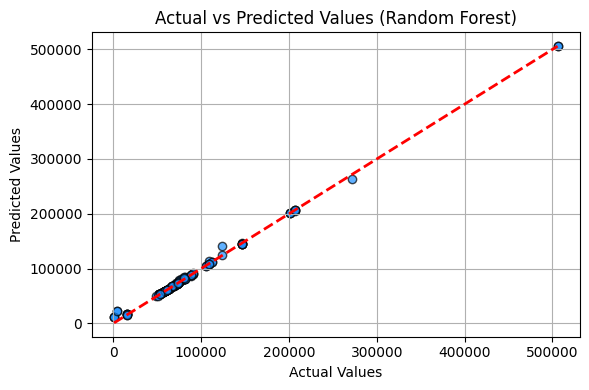

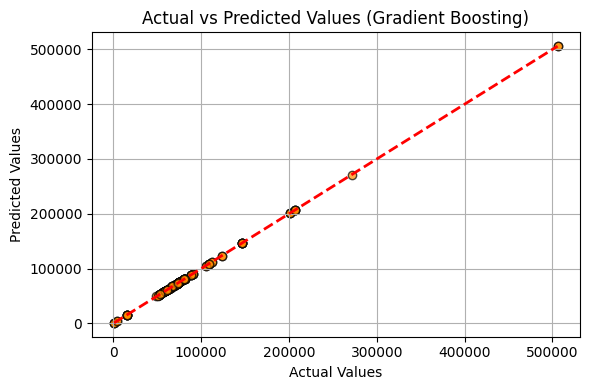

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot for Random Forest Regressor
plt.figure(figsize=(6, 4))  # Smaller plot size
plt.scatter(y_test, y_pred_rf, color='dodgerblue', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2)  # Line representing perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Random Forest)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot for Gradient Boosting Regressor
plt.figure(figsize=(6, 4))  # Smaller plot size
plt.scatter(y_test, y_pred_gb, color='darkorange', edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2)  # Line representing perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Gradient Boosting)')
plt.grid(True)
plt.tight_layout()
plt.show()


Model Understanding                                                                                                                               
Feature Importance for Random Forest

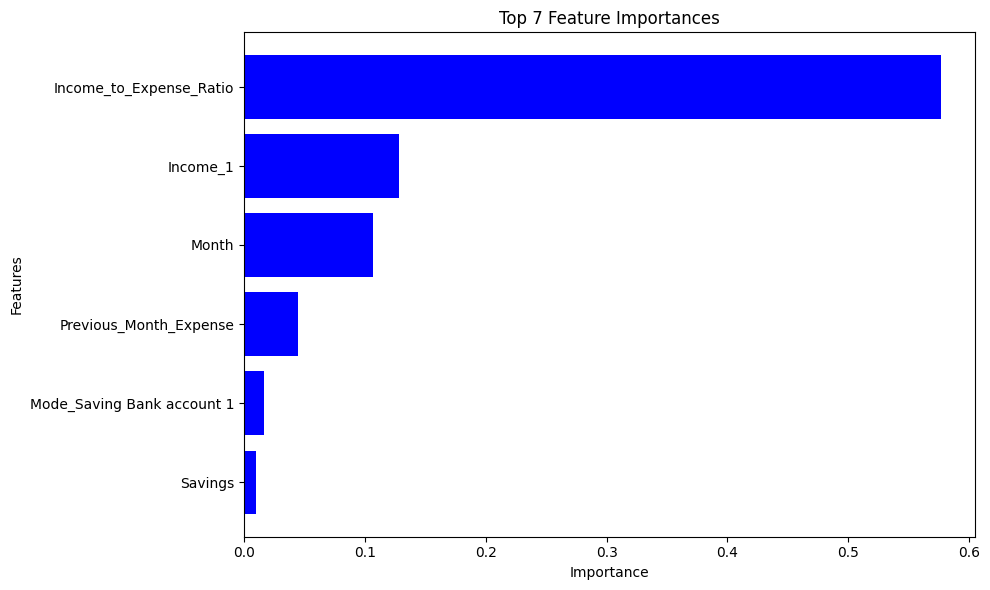

In [ ]:

from sklearn.ensemble import RandomForestRegressor

# Assuming X_train is already prepared and rf_model is trained.
# Check if X_train is a DataFrame or NumPy array, convert to appropriate format
if isinstance(X_train, np.ndarray):
    # Automatically generate feature names if X_train is a NumPy array
    feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]
    X_train_df = pd.DataFrame(X_train, columns=feature_names)
elif isinstance(X_train, pd.DataFrame):
    # If X_train is already a DataFrame, use its column names directly
    X_train_df = X_train.copy()
else:
    raise ValueError("X_train must be either a NumPy array or a DataFrame.")

# Identify duplicate columns and rename them
duplicate_columns = X_train_df.columns[X_train_df.columns.duplicated()].unique()
for col in duplicate_columns:
    duplicates = X_train_df.columns[X_train_df.columns == col]
    for i in range(1, len(duplicates)):
        X_train_df.rename(columns={duplicates[i]: f"{col}_{i}"}, inplace=True)

# Step 3: Train the Random Forest Regressor model (if not already trained)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_df, y_train)

# Step 4: Extract feature importances from the Random Forest model
feature_importances = pd.DataFrame({
    'features': X_train_df.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index(drop=True)

# Sort the feature importances in descending order and select the top 8
top_features = feature_importances.sort_values(by='importance', ascending=False).head(7)

# Plot the top 7 feature importances (in the correct order, most important at the top)
plt.figure(figsize=(10, 6))
plt.barh(top_features['features'][::-1], top_features['importance'][::-1], color='blue', align='center')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 7 Feature Importances')
plt.tight_layout()
plt.show()







Based on the feature importance chart, we can derive the following insights:

**Income to Expense Ratio** appears to be the most influential feature in predicting monthly expenses, indicating that the user's balance between income and expenditure significantly impacts future spending.


**Income** is also highly influential, which suggests that higher income levels directly contribute to predicting monthly expense behavior.


**Month** plays an important role, implying that expenses may vary across different months, likely due to seasonal or cyclical spending behaviors.

**Previous Month's** Expense also ranks high, which highlights the continuity in spending behavior, where past expenses influence future predictions.

The **Mode of Paymen**t for certain categories (e.g., 'Saving Bank account 1') affects spending, indicating preferences in how people manage payments.

**Savings** is also an important feature, suggesting a strong connection between savings trends and expense behavior.


These insights can be useful for understanding what factors most affect spending patterns and could be used for personalized financial advice, such as encouraging better saving habits or optimizing spending to align with income trends.

In [ ]:
import numpy as np
import pandas as pd

import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
 # Suppress warnings about feature names
warnings.filterwarnings("ignore", message="X does not have valid feature names")

# Step 1: Make sure the model has already been fitted
try:
    if not hasattr(gb_model, "feature_importances_"):
        gb_model.fit(X_train, y_train)
    if not hasattr(rf_model, "feature_importances_"):
        rf_model.fit(X_train, y_train)
    if not hasattr(lr_model, "coef_"):
        lr_model.fit(X_train, y_train)
    print("Models have been fitted successfully.")
except Exception as e:
    print("Error while fitting models:", e)

# Step 2: Use the mean of X_test as the input features for the next month's prediction
# Ensure X_test is converted to a NumPy array if it isn't already
features_for_next_month = X_test.mean(axis=0).values.reshape(1, -1)

# Step 3: Predicting the total monthly expense using the Gradient Boosting model
try:
    predicted_expense_gb = gb_model.predict(features_for_next_month)
    print("Predicted Total Monthly Expense (Gradient Boosting Regressor): INR {:.2f}".format(predicted_expense_gb[0]))
except Exception as e:
    print("Error during Gradient Boosting prediction:", e)

# Step 4: Predicting the total monthly expense using the Random Forest model
try:
    predicted_expense_rf = rf_model.predict(features_for_next_month)
    print("Predicted Total Monthly Expense (Random Forest Regressor): INR {:.2f}".format(predicted_expense_rf[0]))
except Exception as e:
    print("Error during Random Forest prediction:", e)

# Step 5: Predicting the total monthly expense using Linear Regression as a baseline
try:
    predicted_expense_lr = lr_model.predict(features_for_next_month)
    print("Predicted Total Monthly Expense (Linear Regression): INR {:.2f}".format(predicted_expense_lr[0]))
except Exception as e:
    print("Error during Linear Regression prediction:", e)


Models have been fitted successfully.
Predicted Total Monthly Expense (Gradient Boosting Regressor): INR 87262.96
Predicted Total Monthly Expense (Random Forest Regressor): INR 74971.17
Predicted Total Monthly Expense (Linear Regression): INR 88998.09
